In [2]:
import sys
main_dir = '../'
sys.path.append(main_dir)

import re, time, math
import subprocess
import numpy as np
import cmasher as cmr
from scipy.special import comb
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors

import matplotlib.gridspec as gridspec
import warnings
warnings.filterwarnings("ignore")

plt.style.use(main_dir+'sty.mplstyle')
src_dir = main_dir+"../OpenNu"

### Call the C++ executable in steady-state method (--fast)

In [3]:
def fastJz(N, gamma=0.9):
    exe=src_dir+'/OpenNu'
    state='Ground'
    options = ["--N", str(N), "--gamma", str(gamma), "--state", state, "--fast"]
    command = [exe] + options
    
    result = subprocess.run(command, capture_output=True, text=True)
    output = result.stdout
    match = re.search(r"Jz\s*=\s*(-?\d+(?:\.\d+)?)", output)
    if match:
        Jz_value = float(match.group(1))
    else:
        raise ValueError("Could not extract Jz from output:\n" + output)
    return Jz_value, output

def fastSx(N, gamma=0.9):
    exe=src_dir+'/OpenNu'
    state='Ground'
    options = ["--N", str(N), "--gamma", str(gamma), "--state", state, "--fast"]
    command = [exe] + options
    
    result = subprocess.run(command, capture_output=True, text=True)
    output = result.stdout
    match = re.search(r"Sx\s*=\s*(-?\d+(?:\.\d+)?)", output)
    if match:
        sx_value = float(match.group(1))
    else:
        raise ValueError("Could not extract Sx from output:\n" + output)
    return sx_value, output

In [4]:
li1 = np.arange(10,31,1)
li2 = np.arange(31,1001,10)
li3 = np.array([1500, 2000, 3000, 4000, 5000,10000, 90000])
Nli = np.concatenate([li1,li2, li3])

glist = np.linspace(0.95,0.99,9)

cmap = cm.copper
norm_colors = mcolors.Normalize(vmin=min(glist), vmax=max(glist))
sm = cm.ScalarMappable(cmap=cmap, norm=norm_colors)
sm.set_array([]) 

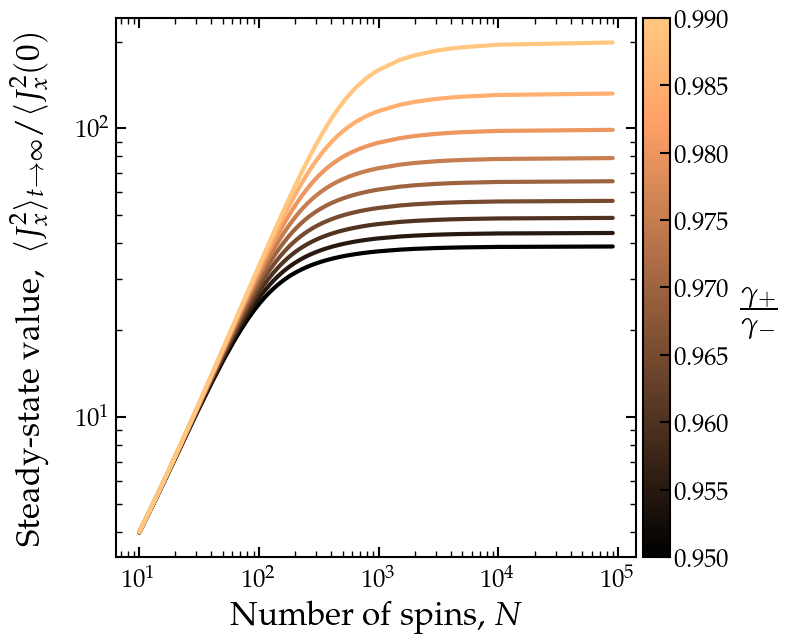

In [13]:
fig, ax = plt.subplots(figsize=(8,7))

for j, gg in enumerate(glist):
    fSx = []
    for i in range(len(Nli)):
        N  = int(Nli[i])
        sx, _ = fastSx(N, gamma=gg)
        fSx.append(sx)
    
    fSx = np.array(fSx)
    color = cmap(norm_colors(gg))
    plt.loglog(Nli, fSx**2/Nli*4,c=color)#, label=r'$\gamma_+/\gamma_-=%.2f$'%gg)


#plt.semilogx(Nli, fSx9**2/Nli*np.sqrt(2)/np.max(fSx9), label=r'$\gamma_+/\gamma_-=0.9$')
#plt.axvline(100, label=r'${\tt qutip}$ limit', c='k', ls='--', lw=1.5,alpha=0.5)
#plt.axvline(1e4, label=r'${\tt OpenNu}$ limit', c='RoyalBlue', ls='--', lw=1.5,alpha=0.5)
# plt.ylim(0.8, 10)

cbar = plt.colorbar(sm, ax=ax, pad=0.01)
cbar.set_label(r'$\frac{\gamma_+}{\gamma_-}$', fontsize=27, rotation=0, labelpad=20)

plt.xlabel(r'Number of spins, $N$', fontsize=24)
plt.ylabel(r'Steady-state value, ~$\langle J_x^2\rangle_{t\to\infty}/\langle J_x^2(0)$', fontsize=24, labelpad=20)
# plt.legend()
plt.show()
fig.savefig(main_dir+'plots/steady.pdf', bbox_inches='tight')

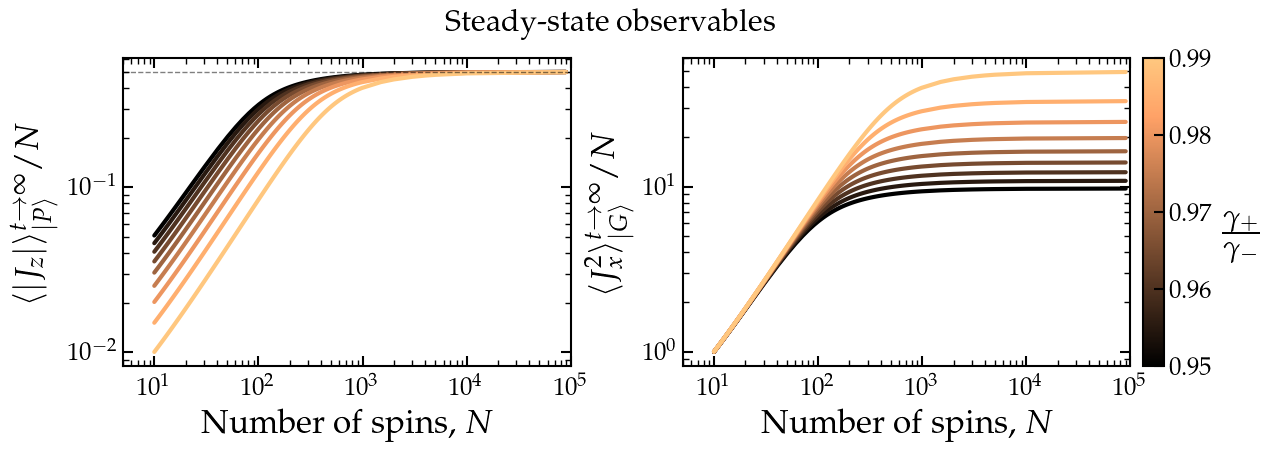

In [5]:
fig = plt.figure(figsize=(13, 4))
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1], wspace=0.25)

ax0 = fig.add_subplot(gs[0])
ax1 = fig.add_subplot(gs[1])

for j, gg in enumerate(glist):
    fjz = []
    fSx = []
    for i in range(len(Nli)):
        N = int(Nli[i])
        jz, _ = fastJz(N, gamma=gg)
        sx, _ = fastSx(N, gamma=gg)
        fjz.append(jz)
        fSx.append(sx)

    fjz = np.array(fjz)
    fSx = np.array(fSx)

    color = cmap(norm_colors(gg))
    ax0.loglog(Nli, fjz / Nli, c=color)
    ax1.loglog(Nli, fSx**2 / Nli, c=color)

ax0.hlines(0.5, 5, 1e5, color='k',  ls='--', lw=1, alpha=0.5)

                    # [left, bottom, width, height] in figure coordinates (0–1)
cbar_ax = fig.add_axes([0.91, 0.11, 0.016, 0.77])

cbar = plt.colorbar(sm, cax=cbar_ax)
cbar.set_label(r'$\frac{\gamma_+}{\gamma_-}$', fontsize=27, rotation=0, labelpad=20)

for ax in [ax0, ax1]:
    ax.set_xlim(5, 1e5)
    ax.set_xlabel(r'Number of spins, $N$', fontsize=24)

ax0.set_ylabel(r'$\langle \vert J_z\vert \rangle_{\vert P\rangle}^{t\to\infty}/N$', fontsize=24, labelpad=7)
ax1.set_ylabel(r'$\langle J_x^2\rangle_{\vert G\rangle}^{t\to\infty}/N$', fontsize=24, labelpad=7)

fig.suptitle('Steady-state~observables', fontsize=22, y=1) 

plt.tight_layout(rect=[0, 0, 0.88, 1])
plt.show()